In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from bokeh.models import Button, CustomJS, Select, ColumnDataSource, LabelSet, Plot, Circle, LinearAxis, Grid
from bokeh.layouts import column, row
from bokeh.plotting import figure
from bokeh.application import Application
from bokeh.application.handlers import FunctionHandler
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.palettes import all_palettes
from bokeh.models import HoverTool, value, LabelSet,Select, Legend, ColumnDataSource, LinearColorMapper, BasicTicker, PrintfTickFormatter, ColorBar, GeoJSONDataSource
from bokeh.models.mappers import CategoricalColorMapper
from datetime import datetime
from math import *
import json
from bokeh.io import output_file, show
from math import pi
from bokeh.palettes import Blues
from bokeh.transform import cumsum
warnings.filterwarnings('ignore')

%matplotlib inline
%reload_ext autoreload
%autoreload 2

plt.style.use('ggplot')

output_notebook()

Loading BokehJS ...

In [2]:
name = pd.ExcelFile('ABC-Company-Sales.xlsx').sheet_names
sheet = [None]*5

In [3]:
# tách ra 5 sheet từ file excel
with pd.ExcelFile('ABC-Company-Sales.xlsx') as f:
    for i in range(len(name)):
        sheet[i] = pd.read_excel(f, sheet_name=name[i])

In [4]:
# ghép 5 bảng với nhau
df = pd.merge(sheet[0], sheet[1])
for i in range(2, 5):
    df = pd.merge(df, sheet[i])

# sort lại data theo cột id
df = df.sort_values(by=['ID'])

# reset index
df = df.reset_index(drop=True)

df.SalesDate = df.SalesDate.apply(lambda x: x.date())

df['IsForeign'] = df.Country != 'Singapore'
df

,ID,SalesDate,OrderID,CustomerID,SalesPersonID,ProductID,Quantity,Sales,StoreID,Category,...,Latitude,Longitude,SalesPersonName,Title,Country,CustomerName,Gender,Phone,PostalCode,IsForeign
0,1,2015-01-01,10381,46,2,74,14,428.260000,8,Children's Clothes,...,1.30124,103.905230,Erik Presley,President,Singapore,Tony Montana,Female,(9) 331-6954,3508,False
1,2,2015-01-01,10382,19,3,5,32,179.840000,2,Men's Clothes,...,1.37974,103.764400,Rob Carsson,Sales Representative,UK,Greg Thatcher,Female,(171) 555-0297,WX1 6LT,True
2,3,2015-01-01,10382,19,3,18,9,241.020000,6,Baby Clothes,...,1.31101,103.796270,Rob Carsson,Sales Representative,UK,Greg Thatcher,Female,(171) 555-0297,WX1 6LT,True
3,4,2015-01-01,10382,19,3,29,14,1811.320000,2,Men's Footwear,...,1.37974,103.764400,Rob Carsson,Sales Representative,UK,Greg Thatcher,Female,(171) 555-0297,WX1 6LT,True
4,5,2015-01-01,10382,19,3,33,60,1649.400000,6,Sportswear,...,1.31101,103.796270,Rob Carsson,Sales Representative,UK,Greg Thatcher,Female,(171) 555-0297,WX1 6LT,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17027,17028,2017-12-12,15630,19,3,21,8,86.648383,3,Sportswear,...,1.39187,103.894820,Rob Carsson,Sales Representative,UK,Greg Thatcher,Female,(171) 555-0297,WX1 6LT,True
17028,17029,2017-12-12,15630,19,3,39,5,295.622144,3,Women's Clothes,...,1.39187,103.894820,Rob Carsson,Sales Representative,UK,Greg Thatcher,Female,(171) 555-0297,WX1 6LT,True
17029,17030,2017-12-12,15776,50,4,25,11,145.240185,6,Sportswear,...,1.31101,103.796270,Joan Callins,Sales Coordinator,Singapore,Marco Van Deum,Female,(02) 201 24 67,B-1180,False
17030,17031,2017-12-12,15776,50,4,27,37,1519.039036,6,Sportswear,...,1.31101,103.796270,Joan Callins,Sales Coordinator,Singapore,Marco Van Deum,Female,(02) 201 24 67,B-1180,False


In [5]:
# Tính tổng doanh thu và số lượng sản phẩm bán được mỗi ngày
df1 = df.groupby('SalesDate').sum().loc[:,['Quantity', 'Sales']].reset_index()
df1

,SalesDate,Quantity,Sales
0,2015-01-01,5300,173878.513202
1,2015-01-02,6517,220697.136128
2,2015-01-03,1522,37603.717994
3,2015-01-04,99,5969.005562
4,2015-01-05,104,1617.189017
...,...,...,...
411,2017-12-08,605,19726.531204
412,2017-12-09,692,13929.489541
413,2017-12-10,696,16884.285560
414,2017-12-11,479,13904.771426


# Biểu  đồ doanh thu theo ngày và top 5 ngày có doanh thu cao nhất

In [6]:
# Lấy top 5 ngày có doanh thu cao nhất
index_of_top_5_day = df1.sort_values(by='Quantity', ascending=False)[:5].index

# sources
source_circle = ColumnDataSource(pd.DataFrame(dict(
    SalesDate=[df1.loc[i][0] for i in index_of_top_5_day],
    Sales=[df1.loc[i][2] for i in index_of_top_5_day]
)))

source_line = ColumnDataSource(df1)


from bokeh.models.transforms import LinearInterpolator

size_mapper = LinearInterpolator(
    x=[df1.Sales.min(), df1.Sales.max()],
    y=[1, 30]
)

TOOLS = 'save, pan, box_zoom, wheel_zoom, reset'

p = figure(
    x_axis_type='datetime', 
    plot_height=500,
    plot_width=800,
    tools=TOOLS,
)
output_file('hi.html')
p.line(x='SalesDate', y='Sales', source=source_line, line_color='#009FB7', line_width=3)
p.circle(
    x='SalesDate', 
    y='Sales', 
    source=source_circle, 
    size={
        'field': 'Sales',
        'transform': size_mapper
    },
    color='#3E7CB1'
)

p.add_tools(HoverTool(
    tooltips="<b>Date: </b> @SalesDate{%F} <br> <b>Sales: </b> @Sales{$ 0.00 a}",
    formatters={'@SalesDate': 'datetime'},
    mode='mouse'
))

p.xaxis.axis_label = 'Date'
p.yaxis.axis_label = 'Sales'
p.title.text = 'Doanh thu theo ngày và top 5 ngày có doanh thu cao nhất'
show(p)

- tháng 1 bán được nhiều

# Biểu đồ thể hiện số lượng loại mặt hàng của từng sản phẩm.

In [7]:
# Tính tổng doanh thu của từng store
region_df = df.groupby(['Store', 'Latitude', 'Longitude', 'StoreID']).sum()[['Sales']].reset_index()

# Thêm img cho từng store
region_df['img'] = [
    'https://www.traveldailymedia.com/assets/2019/09/shutterstock_1160757373.png',
    'https://lifestyle2.prod.content.iproperty.com/news/wp-content/uploads/sites/2/2018/01/05164824/Bukit-Panjang-Plaza.jpg',
    'https://insideretail.asia/wp-content/uploads/2020/09/Compass-Point-2.jpg',
    'https://www.straitstimes.com/sites/default/files/articles/2018/04/10/nm-gwc-1004.jpg',
    'https://www.hdb.gov.sg/cs/infoweb/-/media/HDBContent/Images/PLG/bannerhdbhub.jpg',
    'https://www.toursingapore.net.vn/images/dia-diem/Holland-Village-6.jpg',
    'https://www.todayonline.com/sites/default/files/styles/new_app_article_detail/public/photos/43_images/20201019_jurong_point_google_maps.jpg?itok=gPl2mMV1',
    'https://owa.bestprice.vn/images/destinations/uploads/marina-square-5ea661685750e.jpg',
    'https://media-cdn.tripadvisor.com/media/photo-s/07/bf/02/41/parkway-parade.jpg'
]
region_df

,Store,Latitude,Longitude,StoreID,Sales,img
0,Airport Terminal 1,1.35732,103.987309,7,1.443581e+06,https://www.traveldailymedia.com/assets/2019/0...
1,Bukit Panjang Plaza,1.37974,103.764400,2,1.736684e+06,https://lifestyle2.prod.content.iproperty.com/...
2,Compass Point,1.39187,103.894820,3,1.605814e+06,https://insideretail.asia/wp-content/uploads/2...
3,Great World City,1.29266,103.832490,5,1.203205e+06,https://www.straitstimes.com/sites/default/fil...
4,HDB Hub,1.33239,103.848133,4,1.392243e+06,https://www.hdb.gov.sg/cs/infoweb/-/media/HDBC...
5,Holland Village,1.31101,103.796270,6,2.312533e+06,https://www.toursingapore.net.vn/images/dia-di...
6,Jurong Point,1.34032,103.706006,1,2.432999e+06,https://www.todayonline.com/sites/default/file...
7,Marina Square,1.29136,103.857860,9,1.057786e+06,https://owa.bestprice.vn/images/destinations/u...
8,Parkway Parade,1.30124,103.905230,8,1.064502e+06,https://media-cdn.tripadvisor.com/media/photo-...


In [8]:
region_df.Sales.sum()

14249345.80333811

In [9]:
# Đếm số lượng loại sản phẩm của từng loại hàng
category_df = sheet[1].groupby('Category').count().reset_index()
category_df

,Category,ProductID,Product
0,Baby Clothes,11,11
1,Children's Clothes,4,4
2,Men's Clothes,8,8
3,Men's Footwear,7,7
4,Sportswear,18,18
5,Swimwear,6,6
6,Women's Clothes,16,16
7,Women's Footwear,7,7


In [10]:
p = figure(x_range=category_df['Category'], plot_height=550, plot_width = 800, title="Biểu đồ thể hiện số lượng loại sản phẩm mỗi thể loại (category)",
           toolbar_location=None, tools="hover", tooltips="<b>@x: @top</b>" )

p.vbar(x=category_df['Category'], top = category_df['Product'], color = all_palettes['Pastel1'][8] , width=0.9)
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.axis_label = 'Category'
p.yaxis.axis_label = 'Product Count'
show(p)

# Biểu đồ doanh thu bán hàng của mỗi nhân viên

In [11]:
sum_sales = dict()
for i in sheet[0][['SalesPersonID', 'Sales']].values:
    d = int(i[0])
    sum_sales[d] = i[1] if (d not in sum_sales) else sum_sales[d] + i[1]
sum_sales = {sheet[3][sheet[3]['SalesPersonID'] == i]['SalesPersonName'][i - 1] : j for i, j in sum_sales.items()}

In [12]:
sum_sales_df = pd.DataFrame(sum_sales.items())
sum_sales_df.columns = ['SalesPersonName', 'Sales']
sum_sales_df

,SalesPersonName,Sales
0,Erik Presley,5.555915e+05
1,Rob Carsson,2.797928e+06
2,Leif Shine,2.052004e+06
3,Joan Callins,7.858968e+05
4,Lennart Skoglund,9.275557e+05
5,Ingrid Hendrix,6.741245e+05
6,Tom Lindwall,2.189769e+06
7,Frank Roll,2.162629e+06
8,Helen Brolin,2.103847e+06


In [13]:
sum_sales_df.Sales = sum_sales_df.Sales.apply(lambda x: ceil(x))
src = ColumnDataSource(sum_sales_df)
sum_sales_df['color'] = all_palettes['Paired'][9]
color_mapper = CategoricalColorMapper(palette=all_palettes['Paired'][9])

from bokeh.transform import factor_cmap

p = figure(x_range=sum_sales_df['SalesPersonName'], plot_height=600, plot_width = 900, 
           title="Doanh số bán hàng của từng nhân viên",
           toolbar_location=None)

labels = LabelSet(x='SalesPersonName', y='Sales', text='Sales', level='glyph', text_align='center',
        x_offset=0, y_offset=0, source=src, render_mode='canvas')

p.vbar(x='SalesPersonName', top='Sales', source=src, 
       width=0.8,
       line_color='white', fill_color=factor_cmap('SalesPersonName', palette=all_palettes['Paired'][9], factors=sum_sales_df['SalesPersonName'])
)

p.add_layout(labels)

p.add_tools(HoverTool(
    tooltips="""
        <div>
            <b>Name: </b>@SalesPersonName <br>
            <b>Title: </b>@Title <br>
            <b>Sales: </b>@Sales{$ 0,000}
        </div>
    """
))
p.xaxis.axis_label = 'Employee'
p.yaxis.axis_label = 'Sales'
show(p)

In [14]:
sheet[2].iloc[:, 1] = sheet[2].iloc[:, 1].str.strip()
sheet[2]

,StoreID,Region,Store,Latitude,Longitude
0,1,West,Jurong Point,1.34032,103.706006
1,2,West,Bukit Panjang Plaza,1.37974,103.764400
2,3,North,Compass Point,1.39187,103.894820
3,4,Central,HDB Hub,1.33239,103.848133
4,5,South,Great World City,1.29266,103.832490
5,6,South,Holland Village,1.31101,103.796270
6,7,East,Airport Terminal 1,1.35732,103.987309
7,8,East,Parkway Parade,1.30124,103.905230
8,9,South,Marina Square,1.29136,103.857860


In [15]:
sales_store_id = sheet[0].groupby('StoreID').sum()[['Sales']]
sales_store_id

,Sales
StoreID,
1,2.432999e+06
2,1.736684e+06
3,1.605814e+06
4,1.392243e+06
5,1.203205e+06
6,2.312533e+06
7,1.443581e+06
8,1.064502e+06
9,1.057786e+06


# Biểu đồ cơ cấu doanh thu giữa các vùng

In [16]:
sales_store_id['StoreID'] = sales_store_id.index
sales_store_id.index = np.arange(len(sales_store_id))
sales_store_id

,Sales,StoreID
0,2.432999e+06,1
1,1.736684e+06,2
2,1.605814e+06,3
3,1.392243e+06,4
4,1.203205e+06,5
5,2.312533e+06,6
6,1.443581e+06,7
7,1.064502e+06,8
8,1.057786e+06,9


In [17]:
region_sales = {}
for i,j in sales_store_id.values:
    d = sheet[2][sheet[2].StoreID == int(j)]['Region'].values[0]
    if d in region_sales:
        region_sales[d] += i
    else: region_sales[d] = i
region_sales

{'West': 4169683.43664483,
 'North': 1605813.5394695112,
 'Central': 1392242.5094300061,
 'South': 4573523.916882313,
 'East': 2508082.4009114504}

In [18]:
sum_store_sales = sum(region_sales.values())
region_sales_percent = {}
for i,j in region_sales.items():
    region_sales_percent[i] = (j / sum_store_sales) * 100
region_sales_percent

{'West': 29.262279785981633,
 'North': 11.269384304599631,
 'Central': 9.77057142583945,
 'South': 32.09637817766273,
 'East': 17.60138630591656}

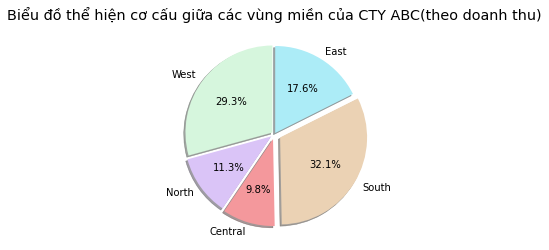

In [19]:
dic = pd.DataFrame(region_sales_percent.items())
dic.columns = ['Region', 'SalesPercent']
my_colors = ['#D6F6DD','#DAC4F7','#F4989C','#EBD2B4','#ACECF7'] 
plt.pie(dic['SalesPercent'], labels=dic['Region'], autopct = '%1.1f%%', shadow=True,
        startangle=90, explode=(0.03, 0.045, 0.06, 0.075, 0.015),colors = my_colors)
plt.title("Biểu đồ thể hiện cơ cấu giữa các vùng miền của CTY ABC(theo doanh thu)")

plt.show()

In [20]:
dic['SalesPercent'] = dic['SalesPercent'].apply(lambda x: round(x,2))
dic['SalesPercent']

0    29.26
1    11.27
2     9.77
3    32.10
4    17.60
Name: SalesPercent, dtype: float64

In [21]:
data = pd.Series(region_sales_percent).reset_index(name='value').rename(columns={'index':'country'})
p = figure(plot_height=500, title="Pie Chart", toolbar_location=None,
        tools="hover", tooltips="<b>@country</b>: @value{0.2f}%")
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = Blues[len(region_sales_percent)]
data['SalesPercent'] = dic['SalesPercent']
p.wedge(x=0, y=1, radius=0.6,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend='country', source=data)
source = ColumnDataSource(data)

# dic["SalesPercent"] = dic["SalesPercent"].str.pad(35, side = "left")
labels = LabelSet(x=0, y=1, text='SalesPercent',
        angle=cumsum('angle', include_zero=True), source=source,text_align='center')
# p.add_layout(labels)
show(p)

# Biểu đồ sản phẩm bán được theo từng khu vực

In [22]:
regions_product_sales = sheet[0].groupby('StoreID').count()[['ProductID']]
regions_product_sales

,ProductID
StoreID,
1,2839
2,2088
3,1930
4,1665
5,1439
6,2797
7,1663
8,1191
9,1420


In [23]:
sheet[1][['ProductID', 'Category']].values

array([[10, 'Baby Clothes'],
       [13, 'Baby Clothes'],
       [18, 'Baby Clothes'],
       [30, 'Baby Clothes'],
       [36, 'Baby Clothes'],
       [37, 'Baby Clothes'],
       [40, 'Baby Clothes'],
       [41, 'Baby Clothes'],
       [46, 'Baby Clothes'],
       [58, 'Baby Clothes'],
       [73, 'Baby Clothes'],
       [7, "Children's Clothes"],
       [14, "Children's Clothes"],
       [28, "Children's Clothes"],
       [74, "Children's Clothes"],
       [1, "Men's Clothes"],
       [5, "Men's Clothes"],
       [11, "Men's Clothes"],
       [24, "Men's Clothes"],
       [31, "Men's Clothes"],
       [70, "Men's Clothes"],
       [71, "Men's Clothes"],
       [75, "Men's Clothes"],
       [9, "Men's Footwear"],
       [17, "Men's Footwear"],
       [29, "Men's Footwear"],
       [45, "Men's Footwear"],
       [47, "Men's Footwear"],
       [48, "Men's Footwear"],
       [51, "Men's Footwear"],
       [2, 'Sportswear'],
       [16, 'Sportswear'],
       [19, 'Sportswear'],
       [

In [24]:
map_regions = dict()
for i, j in sheet[2][['StoreID', 'Region']].values:
    map_regions[i] = j
map_regions

{1: 'West',
 2: 'West',
 3: 'North',
 4: 'Central',
 5: 'South',
 6: 'South',
 7: 'East',
 8: 'East',
 9: 'South'}

In [25]:
map_category = dict()
for i, j in sheet[1][['ProductID', 'Category']].values:
    map_category[i] = j
map_category

{10: 'Baby Clothes',
 13: 'Baby Clothes',
 18: 'Baby Clothes',
 30: 'Baby Clothes',
 36: 'Baby Clothes',
 37: 'Baby Clothes',
 40: 'Baby Clothes',
 41: 'Baby Clothes',
 46: 'Baby Clothes',
 58: 'Baby Clothes',
 73: 'Baby Clothes',
 7: "Children's Clothes",
 14: "Children's Clothes",
 28: "Children's Clothes",
 74: "Children's Clothes",
 1: "Men's Clothes",
 5: "Men's Clothes",
 11: "Men's Clothes",
 24: "Men's Clothes",
 31: "Men's Clothes",
 70: "Men's Clothes",
 71: "Men's Clothes",
 75: "Men's Clothes",
 9: "Men's Footwear",
 17: "Men's Footwear",
 29: "Men's Footwear",
 45: "Men's Footwear",
 47: "Men's Footwear",
 48: "Men's Footwear",
 51: "Men's Footwear",
 2: 'Sportswear',
 16: 'Sportswear',
 19: 'Sportswear',
 20: 'Sportswear',
 21: 'Sportswear',
 25: 'Sportswear',
 26: 'Sportswear',
 27: 'Sportswear',
 33: 'Sportswear',
 49: 'Sportswear',
 54: 'Sportswear',
 55: 'Sportswear',
 59: 'Sportswear',
 60: 'Sportswear',
 61: 'Sportswear',
 62: 'Sportswear',
 68: 'Sportswear',
 69: '

In [26]:
map_quantity_regions = dict()
map_sale_regions = dict()
for i, j, k, l in sheet[0][['ProductID', 'Quantity', 'Sales', 'StoreID']].values:
    if map_regions[l] not in map_quantity_regions:
        map_quantity_regions[map_regions[l]] = dict()
    if map_category[i] in map_quantity_regions[map_regions[l]]:
        map_quantity_regions[map_regions[l]][map_category[i]] += j
    else: map_quantity_regions[map_regions[l]][map_category[i]] = j
dat = pd.DataFrame(map_quantity_regions['West'].items())
dat.columns = ['Category', 'Quantity']
dat

,Category,Quantity
0,Men's Clothes,19599.0
1,Men's Footwear,9089.0
2,Women's Clothes,20974.0
3,Sportswear,34881.0
4,Baby Clothes,17723.0
5,Women's Footwear,11004.0
6,Children's Clothes,5054.0
7,Swimwear,6528.0


In [27]:
map_quantity_regions['West']

{"Men's Clothes": 19599.0,
 "Men's Footwear": 9089.0,
 "Women's Clothes": 20974.0,
 'Sportswear': 34881.0,
 'Baby Clothes': 17723.0,
 "Women's Footwear": 11004.0,
 "Children's Clothes": 5054.0,
 'Swimwear': 6528.0}

In [28]:
map_products = dict()
for j in df['Category'].unique():
    for i in df[['Quantity', 'Category']].values:
        d = int(i[0])
        if i[1] == j:
            map_products[j] = d if j not in map_products else map_products[j] + d
tmp = sorted(map_products.keys())
ret = dict()
for i in tmp:
    ret[i] = map_products[i]
map_products = ret
for i in map_quantity_regions:
    ret = dict()
    for j in tmp:
        ret[j] = map_quantity_regions[i][j]
    map_quantity_regions[i] = ret

In [29]:
df1 = pd.DataFrame()
df1 = pd.DataFrame(columns=['P', 'R', 'S'])
for i in map_quantity_regions:
    for j in map_quantity_regions[i]:
        df1 = df1.append({'R' : i, 'P': j, 'S' : map_quantity_regions[i][j]}, ignore_index=True)
df1
dic = dict()
for i in map_quantity_regions:
    dic[i] = df1[df1.R == i][['P', 'S']]
print(dic['West']['P'])
df1

8           Baby Clothes
9     Children's Clothes
10         Men's Clothes
11        Men's Footwear
12            Sportswear
13              Swimwear
14       Women's Clothes
15      Women's Footwear
Name: P, dtype: object


,P,R,S
0,Baby Clothes,East,9909.0
1,Children's Clothes,East,2974.0
2,Men's Clothes,East,10329.0
3,Men's Footwear,East,5079.0
4,Sportswear,East,21437.0
5,Swimwear,East,4204.0
6,Women's Clothes,East,12741.0
7,Women's Footwear,East,6802.0
8,Baby Clothes,West,17723.0
9,Children's Clothes,West,5054.0


In [30]:
menu = [(i, i) for i in map_quantity_regions]
src = ColumnDataSource(dic['West'])

select = Select(title='Options:', value='West', options=menu)

def update(attr, old, new):
    src.data = dic[select.value]
select.on_change('value', update)
retP = src.data['P'].tolist()
p = figure(x_range= retP, plot_height=550, plot_width = 800, title="Doanh thu từng sản phẩm của từng khu vực",
           toolbar_location=None, tools="hover, save", tooltips="<b>@P: @S{($ 0.00 a)}</b>")


labels = LabelSet(x='P', y='S', text='S', level='glyph',
        source=src, render_mode='canvas', text_align = 'center')

p.add_layout(labels)

p.vbar(x='P', top = 'S', source = src, color = '#00b2ca' , width=0.75)
p.xgrid.grid_line_color = None
p.y_range.start = 0
def modify_doc(doc):
    doc.add_root(row(p, select))

handler = FunctionHandler(modify_doc)
app = Application(handler)
p.title.text_font = "DejaVu Sans"
p.title.text_font_style = "bold"

show(app)

In [31]:
source = ColumnDataSource(dic)

p = figure(x_range=source.data['West']['P'], plot_width=900, plot_height=500, toolbar_location=None, title="Biểu đồ thể hiện doanh thu của từng sản phẩm theo vùng")
p.line(x=source.data['South']['P'], y=source.data['South']['S'], line_width=4, legend_label="South",
       line_dash_offset = 1, line_color='#adbabd')
p.line(x=source.data['East']['P'], y=source.data['East']['S'], line_width=4, legend_label = 'East', 
       line_dash_offset = 1, color = 'lightskyblue')
p.line(x=source.data['West']['P'], y=source.data['West']['S'], line_width=4, legend_label='West',
       line_dash_offset = 1, line_color='#7dd181')
p.line(x=source.data['North']['P'], y=source.data['North']['S'], line_width=4, legend_label="North",
       line_dash_offset = 1, line_color='#e57a44')
p.line(x=source.data['Central']['P'], y=source.data['Central']['S'], line_width=4, legend_label="Central",
       line_dash_offset = 1, line_color='#edd83d')
p.circle(x=source.data['East']['P'], y = source.data['East']['S'], size=6,
         line_color="lightskyblue", fill_color="lightskyblue", line_width=3)
p.circle(x=source.data['West']['P'], y = source.data['West']['S'], size=6,
         line_color="#7dd181", fill_color="#7dd181", line_width=3)
p.circle(x=source.data['North']['P'], y = source.data['North']['S'], size=6,
         line_color="#e57a44", fill_color="#e57a44", line_width=3)
p.circle(x=source.data['Central']['P'], y = source.data['Central']['S'], size=6,
         line_color="#edd83d", fill_color="#edd83d", line_width=3)
p.circle(x=source.data['South']['P'], y = source.data['South']['S'], size=6,
         line_color="#adbabd", fill_color="#adbabd", line_width=3)

show(p)

In [32]:
from bokeh.models import FactorRange, NumeralTickFormatter
from bokeh.transform import dodge

sales_df = df.groupby(['Region', 'IsForeign']).sum()[['Sales']].reset_index()
sales_df.Sales = sales_df.Sales.apply(lambda x: ceil(x))
sales_df = sales_df.sort_values(by=['Sales'])

foreign = ['Foreign', 'Domestic']
region = sales_df.Region.unique()
foreign_sales=sales_df[sales_df.IsForeign == True].Sales
domestic_sales=sales_df[sales_df.IsForeign == False].Sales
mean = (np.asarray(foreign_sales) + np.asarray(domestic_sales)) / 2
mean = mean.astype('int64')

x = [(i, j) for i in region for j in foreign]
x_sales = sum(zip(foreign_sales, domestic_sales), ())

src = ColumnDataSource(data=dict(
    x=x,
    mean=mean,
    region=region,
    x_sales=x_sales,
    foreign_sales=foreign_sales,
    domestic_sales=domestic_sales,
    color=['#55DDE0', '#33658A'] * 5
))

muted_color='#f0f2f0'

p = figure(x_range=FactorRange(*x), plot_height=400, plot_width=900)

p.vbar(x='x', top='x_sales', source=src, width=0.95, color='color', legend_label="Sales", muted_color=muted_color)

# mean
col = '#2F4858'
p.line(x=region, y=mean, color=col, legend_label='Aver Sales', name='line', muted_color=muted_color, line_width=1)
p.circle(x=region, y=mean, size=8, color=col, legend_label='Aver Sales', name='circle', muted_color=muted_color)

labels = LabelSet(x='x', y='x_sales', text='x_sales', source=src, x_offset=6, y_offset=-1, text_align='center',
                 render_mode='css', level='glyph', text_font_size="8pt")

p.add_layout(labels)

p.add_tools(HoverTool(
    tooltips="""
        <b>Aver Sales:</b> @y{$ 0}
    """,
    names=['circle']
))

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.click_policy = "mute"
p.legend.orientation = "horizontal"
p.toolbar.autohide = True
p.title.text = 'Doanh thu khách trong nước và ngoài nước của 5 khu vực'

output_file('line_bar.html')

show(p)

ERROR:tornado.application:Uncaught exception GET /autoload.js?bokeh-autoload-element=2141&bokeh-absolute-url=http://localhost:50007&resources=none (::1)
HTTPServerRequest(protocol='http', host='localhost:50007', method='GET', uri='/autoload.js?bokeh-autoload-element=2141&bokeh-absolute-url=http://localhost:50007&resources=none', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "C:\Users\nvatu\Anaconda3\lib\site-packages\tornado\web.py", line 1703, in _execute
    result = await result
  File "C:\Users\nvatu\Anaconda3\lib\site-packages\bokeh\server\views\autoload_js_handler.py", line 60, in get
    session = await self.get_session()
  File "C:\Users\nvatu\Anaconda3\lib\site-packages\bokeh\server\views\session_handler.py", line 120, in get_session
    session = await self.application_context.create_session_if_needed(session_id, self.request, token)
  File "C:\Users\nvatu\Anaconda3\lib\site-packages\bokeh\server\contexts.py", line 218, in create_session_if_ne

In [33]:
from bokeh.models import FactorRange, NumeralTickFormatter
from bokeh.transform import dodge

sales_df = df.groupby(['Region', 'IsForeign']).sum()[['Sales']].reset_index()
sales_df.Sales = sales_df.Sales.apply(lambda x: ceil(x))
sales_df = sales_df.sort_values(by=['Sales'])

region = sales_df.Region.unique()
foreign_sales=sales_df[sales_df.IsForeign == True].Sales
domestic_sales=sales_df[sales_df.IsForeign == False].Sales
mean = (np.asarray(foreign_sales) + np.asarray(domestic_sales)) / 2
mean = mean.astype('int64')

src = ColumnDataSource(data=dict(
    mean=mean,
    region=region,
    foreign_sales=foreign_sales,
    domestic_sales=domestic_sales,
))

muted_color='#f0f2f0'

p = figure(x_range=region, plot_height=400, plot_width=900)

p.vbar(x=dodge('region', -0.16, range=p.x_range), top='foreign_sales',
      width=0.3, source=src, color='#55DDE0', legend_label='Foreign', muted_color=muted_color)

p.vbar(x=dodge('region', 0.16, range=p.x_range), top='domestic_sales', 
      width=0.3, source=src, color='#33658A', legend_label='Domestic', muted_color=muted_color)

# mean
col = '#2F4858'
p.line(x=dodge('region', 0, range=p.x_range), y='mean', 
       color=col, legend_label='Aver Sales', name='line', source=src, muted_color=muted_color, line_width=1)
p.circle(x=dodge('region', 0, range=p.x_range), y='mean', 
         source=src, size=8, color=col, legend_label='Aver Sales', name='circle', muted_color=muted_color)

foreign_labels = LabelSet(x=dodge('region', -0.15, range=p.x_range), y='foreign_sales', 
                  text='foreign_sales', source=src, x_offset=0, y_offset=0, text_align='center',
                 render_mode='css', level='glyph', text_font_size="8pt")
domestic_labels = LabelSet(x=dodge('region', 0.15, range=p.x_range), y='domestic_sales', 
                  text='domestic_sales', source=src, x_offset=0, y_offset=0, text_align='center',
                 render_mode='css', level='glyph', text_font_size="8pt")


p.add_layout(foreign_labels)
p.add_layout(domestic_labels)

p.add_tools(HoverTool(
    tooltips="""
        <b>Aver Sales:</b> @mean{$ 0,000}
    """,
    names=['circle']
))

p.y_range.start = 0
p.x_range.range_padding = 0.1
# p.xaxis.major_label_orientation = 1
p.xgrid.grid_line_color = None
p.legend.location = "top_left"
p.legend.click_policy = "mute"
# p.legend.orientation = "horizontal"
p.toolbar.autohide = True
p.title.text = 'Doanh thu khách trong nước và ngoài nước của 5 khu vực'

output_file('line_bar.html')

show(p)